2021.08.18 OSM路網分析

- 方法論: https://ithelp.ithome.com.tw/articles/10207559
- 大客車相關管制路段: https://www.thb.gov.tw/page?node=15c7f8ec-42cd-4ab6-9b46-8b46a3e39a9a
    - https://data.gov.tw/suggests/136378

# 讀檔

In [2]:
import geopandas as gpd
import fiona

# 道路中心圖
# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #讀KML才需要
roads = gpd.read_file(r'G:\我的雲端硬碟\python\app\SBIR\sample_data\台中市道路中心線\VL050005V44.shp', 
#                       encoding='big5', 
#                       driver="KML" #讀KML才需要
                     )
# 村里界圖
lee_gdf = gpd.read_file(r'G:\我的雲端硬碟\python\地理圖資\2.村里界圖(TWD97經緯度)\VILLAGE_MOI_1091016.shp', 
                      encoding='utf-8', 
#                       driver="KML"
                     )

roads.head()

,ID,圖名代碼,路名,地區,巷,弄,單雙向,左向車道數,右向車道數,速限,路寬,區分級別,更新年度,備註,X坐標,Y坐標,路長,geometry
0,2542,R0002,英才路,北區,140巷,None,雙,1,1,40,6.0,4,0,None,217097.055,2672350.175,83.37,"LINESTRING Z (217097.214 2672391.860 0.000, 21..."
1,99574,R0002,精誠路,西區,None,None,雙,1,1,40,15.0,4,0,None,214951.131,2671516.645,56.77,"LINESTRING Z (214951.656 2671545.025 0.000, 21..."
2,17897,R0002,文心南七路,南屯區,None,None,雙,1,1,40,10.0,4,0,None,214652.627,2669412.824,213.52,"LINESTRING Z (214545.866 2669413.300 0.000, 21..."
3,9894,R0002,皇龍橋,北屯區,None,None,雙,1,1,40,9.0,4,0,None,224688.163,2675948.255,18.54,"LINESTRING Z (224679.490 2675944.985 0.000, 22..."
4,7212,R0002,None,北屯區,仁友巷,5弄,雙,1,1,40,7.0,4,0,None,222961.005,2674166.819,21.53,"LINESTRING Z (222961.252 2674156.055 0.000, 22..."


In [3]:
roads.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan - 120°E to 122°E
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

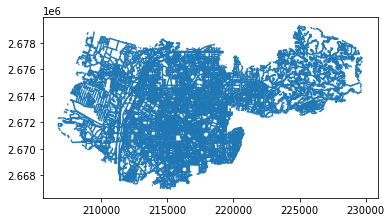

In [4]:
roads.plot()

In [5]:
roads.shape

(28601, 18)

## 幾何驗證

In [93]:
roads.is_valid.all()

True

In [90]:
# if False 解法 (https://stackoverflow.com/questions/63955752/topologicalerror-the-operation-geosintersection-r-could-not-be-performed)
# # roads2 = roads.buffer(0) #會跑一陣子
# roads2.is_valid

In [92]:
lee_gdf.is_valid.all()

True

## Clip 切小塊(使用村里)

- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/clip-vector-data-in-python-geopandas-shapely/

In [8]:
# 挑選村里
mask = (lee_gdf["TOWNNAME"].isin(["西屯區"])) & (lee_gdf["VILLNAME"].isin(["潮洋里"]))
lee_gdf[mask].head()

,VILLCODE,COUNTYNAME,TOWNNAME,VILLNAME,VILLENG,COUNTYID,COUNTYCODE,TOWNID,TOWNCODE,NOTE,geometry
1935,66000060003,臺中市,西屯區,潮洋里,Chaoyang Vil.,B,66000,B06,66000060,None,"POLYGON ((120.63285 24.16081, 120.63038 24.161..."


<AxesSubplot:>

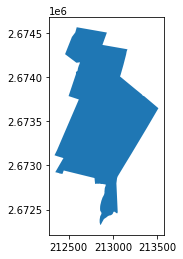

In [9]:
lee_pic = lee_gdf[mask]
lee_pic = lee_pic.to_crs(roads.crs)
lee_pic.plot()

In [19]:
# Clip data
roads_clip = gpd.clip(roads, lee_pic)

# Ignore missing/empty geometries
roads_clip = roads_clip[~roads_clip.is_empty]

print("The clipped data have fewer line objects (represented by rows):",
      roads_clip.shape, roads.shape)

The clipped data have fewer line objects (represented by rows): (231, 18) (28601, 18)


<AxesSubplot:>

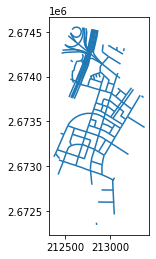

In [20]:
roads_clip.plot()

In [21]:
roads_clip["geometry"].head()

137    LINESTRING Z (213117.312 2673422.460 0.000, 21...
146    LINESTRING Z (213176.974 2673521.910 0.000, 21...
263    LINESTRING Z (213078.593 2674330.643 0.000, 21...
302    LINESTRING Z (213016.350 2673252.500 0.000, 21...
398    LINESTRING Z (212909.994 2674142.688 0.000, 21...
Name: geometry, dtype: geometry

In [22]:
roads_clip["geometry"].type.unique()

array(['LineString', 'MultiLineString'], dtype=object)

In [26]:
# 只LineString (排除 MultiLineString)
mask_type = (roads_clip["geometry"].type =="LineString")
roads_clip_clean = roads_clip.loc[mask_type,:]

In [27]:
# 這邊發現這份路網是linestring Z，我們先把它轉為linestring
from shapely.geometry import shape,LineString,Point
geoms =roads_clip_clean['geometry']

geoms = [LineString([xy[0:2] for xy in list(geom.coords)])  for geom in geoms]
roads_clip_clean['geometry']=geoms
roads_clip_clean["geometry"].head()

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


137    LINESTRING (213117.312 2673422.460, 213142.322...
146    LINESTRING (213176.974 2673521.910, 213194.764...
263    LINESTRING (213078.593 2674330.643, 213076.540...
302    LINESTRING (213016.350 2673252.500, 213206.689...
398    LINESTRING (212909.994 2674142.688, 212895.894...
Name: geometry, dtype: geometry

<AxesSubplot:>

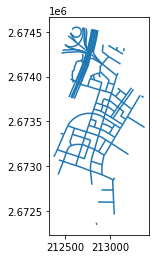

In [28]:
roads_clip_clean.plot()

In [29]:
import folium
map = folium.Map(location=[23.762485, 120.827323], 
                 zoom_start=8, 
                 tiles='http://tile.stamen.com/toner/{z}/{x}/{y}.png', 
                 attr="https://stackoverflow.com/questions/48318538/folium-custom-map-tiles"
                )

# 運禽車完整路線
folium.Choropleth(
    roads_clip_clean,
    line_weight=3,
    line_color='#66B3FF'
).add_to(map)

map

In [31]:
# 確認為linestring後，使用sg ShapeGraph 把shp 或 geometry丟進去
from s2g import ShapeGraph
import networkx as nx

sg = ShapeGraph(geoms=roads_clip_clean.geometry
                , to_graph=True)
g_nw = sg.to_networkx()

INFO:root:Validating pair-wise line connections of raw shapefiles (total 226 lines)
100% (25425 of 25425) |##################| Elapsed Time: 0:00:20 Time:  0:00:20
INFO:root:Processing the largest component with 208 lines
INFO:root:Cutting lines with specific resolution = 1.0 km
100% (208 of 208) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
INFO:root:Adding pseudo edges to eliminate gaps between edges
INFO:root:Graph created with 706 nodes, 625 edges
INFO:root:Processing the largest component with 208 lines
INFO:root:Cutting lines with specific resolution = 1.0 km
100% (208 of 208) |######################| Elapsed Time: 0:00:00 Time:  0:00:00

Major components statistics:
	Total components: 5
	Component size: max 208, median 5.0, min 2, average 44.6
	Top comp. sizes: 208 5 5 3 2



INFO:root:Adding pseudo edges to eliminate gaps between edges
INFO:root:Graph created with 706 nodes, 625 edges


# graph操作

- 最短路徑相關方法: https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html

In [32]:
# 從 start_node 到 end_node 的最短路線規劃
start_node = 1
end_node = 10

nearest_path= nx.shortest_path(g_nw, source=start_node, target=end_node, method='dijkstra')
nearest_path

[1, 170, 127, 33, 196, 197, 472, 273, 330, 147, 29, 6, 7, 8, 9, 10]

C:\Users\EMCT_Jeff\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

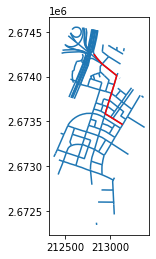

In [33]:
# 繪圖
base=roads_clip_clean.plot()
geoms=[]
for item in nearest_path:
    geoms.append(sg.node_xy[item])

train_lines = gpd.GeoDataFrame(crs= {'init' :'epsg:3826'},geometry=[LineString(geoms)])
train_lines.plot(ax=base,color='red')

In [190]:
# nx.draw(g_nw, with_labels=True, font_weight='bold') # 會跑一小陣子

In [194]:
all_nearest_path= nx.all_shortest_paths(g_nw, source=start_node, target=end_node, method='dijkstra')
for p in all_nearest_path:
    print(p)

[1, 170, 127, 33, 196, 197, 472, 273, 330, 147, 29, 6, 7, 8, 9, 10]
[1, 170, 219, 174, 495, 197, 472, 273, 330, 147, 29, 6, 7, 8, 9, 10]


In [75]:
shortest_path_length= nx.shortest_path_length(g_nw, source=start_node, target=end_node, weight="length")
shortest_path_length # 過了幾個 Node(因為沒有length資訊)

15

In [74]:
g_nw.graph

{}

In [72]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(g_nw)

KeyError: 'crs'

# 使用 OSMNX 取得資料

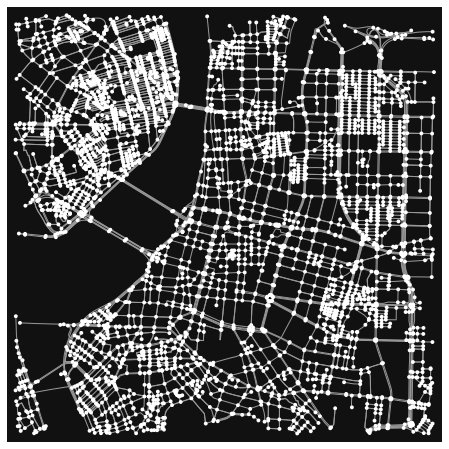

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [56]:
import osmnx as ox
G = ox.graph_from_point((25.048545,121.51123), dist=3000, network_type='drive')
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G) # 取得各 節點 線段 資訊
ox.plot_graph(G) # 會跑一小陣子

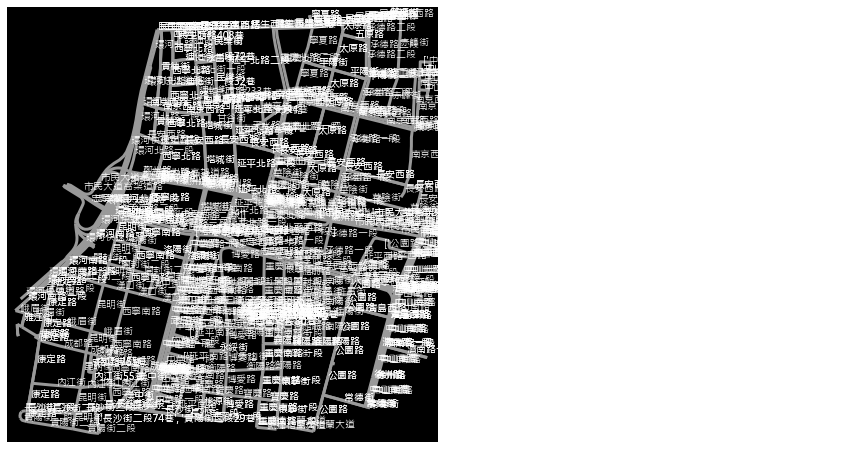

In [43]:
#show 路名
# import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
# plt.rcParams['axes.unicode_minus'] = False

# fig, ax = ox.plot_graph(G, bgcolor='k', edge_linewidth=3, node_size=0,
#                         show=False, close=False)
# for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():
#     c = edge['geometry'].centroid
#     text = edge['name']
#     ax.annotate(text, (c.x, c.y), c='w')
# plt.show()

In [45]:
origin = ox.distance.nearest_nodes(G, Y=25.04757667950531, X=121.51659363968007) #台北車站 
destination = ox.distance.nearest_nodes(G, Y=25.05195422941843, X=121.53316660744505) #松江南京

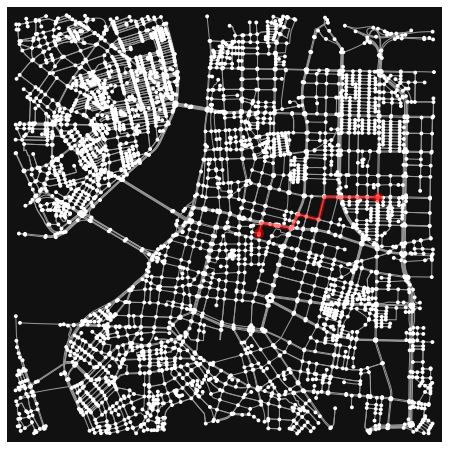

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [46]:
import networkx as nx
route = nx.shortest_path(G, origin, destination)
ox.plot_graph_route(G, route)

## 計算距離

- https://github.com/gboeing/osmnx/issues/267

In [20]:
route_length =  nx.shortest_path_length(G, origin, destination, weight="length")
route_length

2144.302

In [ ]:
# gdf_nodes.head() # 節點資訊
gdf_edges.head() #線段資訊

In [66]:
# 顯示路名
for s,d in zip(route,route[1:]):
    print(G.edges[(s, d, 0)]["name"], G.edges[(s, d, 0)]["length"])

# # 顯示節點資訊 可用於判斷方向
# for n in zip(route):
#     print(G.nodes[n])

承德路一段 149.45999999999998
市民大道一段 219.844
市民大道一段 29.531
市民大道一段 170.951
市民大道一段 9.776
市民大道一段 6.602
中山北路一段 21.435
中山北路一段 201.661
長安東路一段 8.819
長安東路一段 115.572
長安東路一段 176.734
長安東路一段 6.779
林森北路 335.198
南京東路一段 190.677
南京東路一段 24.29
南京東路二段 32.89
南京東路二段 110.39
南京東路二段 112.23400000000001
南京東路二段 142.909
南京東路二段 144.965
南京東路二段 12.945


In [54]:
# 節點資訊
G.edges[(s, d, 0)]

{'osmid': 437870654,
 'oneway': True,
 'lanes': '2',
 'name': '南京東路二段',
 'highway': 'secondary',
 'length': 12.945}

## 服務範圍、等時圈

In [44]:
# 取得中心點node
center_node = ox.distance.nearest_nodes(G, Y=25.02999951271579, X=121.50223412095822)

In [48]:
# 給予每個edge速度，單位是每分鐘的公尺數
meters_per_minute = 10 * 1000 / 60 # 每小時10公里
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [59]:
# 官網提供的範例是利用networkx的ego_graph，
# ego_graph會回傳一個graph中心點一定範圍的節點子graph，
# 運算的單位可以是edge的weight等等，
# 這邊範例是使用time（所以要配合上面先提供每個edge'time'），
# 詳請請看networkx官方文件。

import networkx as nx
trip_times = [5, 10, 15, 20, 25] #分鐘
# 給定顏色
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color # 抵達的node給顏色

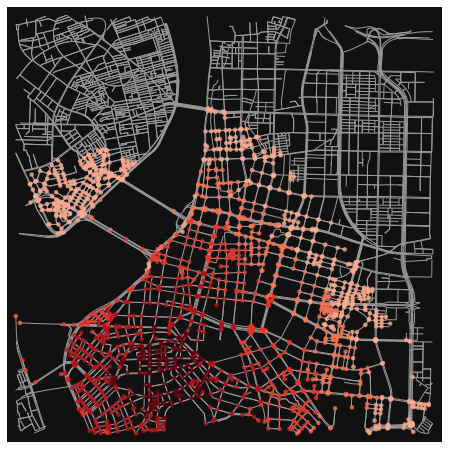

In [60]:
# 根據上面抵達的node邊界，再給一次範圍內的顏色，並畫圖
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

# 有條件最短路徑

- 最短路徑演算法: https://ithelp.ithome.com.tw/articles/10252710
- 有條件最短路徑: https://iter01.com/600024.html

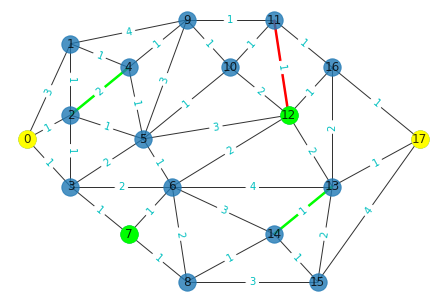

In [112]:
import matplotlib.pyplot as plt # 匯入 Matplotlib 工具包
import networkx as nx  # 匯入 NetworkX 工具包

# 問題 1：螞蟻的最優路徑分析
# 3.1 圖的建立和視覺化

gAnt = nx.Graph()  # 建立：空的 無向圖
gAnt.add_weighted_edges_from([(0,1,3),(0,2,1),(0,3,1),
                            (1,2,1),(1,4,1),(1,9,4),
                            (2,3,1),(2,4,2),(2,5,1),
                            (3,5,2),(3,6,2),(3,7,1),
                            (4,5,1),(4,9,1),
                            (5,6,1),(5,9,3),(5,10,1),(5,12,3),
                            (6,7,1),(6,8,2),(6,12,2),(6,13,4),(6,14,3),
                            (7,8,1),
                            (8,14,1),(8,15,3),
                            (9,10,1),(9,11,1),
                            (10,11,1),(10,12,2),
                            (11,12,1),(11,16,1),
                            (12,13,2),(12,16,1),
                            (13,14,1),(13,15,2),(13,16,2),(13,17,1),
                            (14,15,1),
                            (15,17,4),
                            (16,17,1)])  # 向圖中新增多條賦權邊: (node1,node2,weight)

pos={0:(1,8),1:(4,12),2:(4,9),3:(4,6),4:(8,11),5:(9,8),  # 指定頂點位置
     6:(11,6),7:(8,4),8:(12,2),9:(12,13),10:(15,11),11:(18,13),
     12:(19,9),13:(22,6),14:(18,4),15:(21,2),16:(22,11),17:(28,8)}
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
plt.show()

In [ ]:
# 程式說明

# 圖的建立。本例使用 nx.Graph() 建立無向圖，然後用 gAnt.add_weighted_edges_from() 函式以列表向圖中新增多條賦權邊，每個賦權邊以元組 (node1,node2,weight) 表示。
# 圖的繪製。使用nx.draw()繪圖時，預設的節點位置並不理想，可以使用 pos 屬性引數指定節點位置。pos 為字典資料型別，按 node:(x_pos,y_pos) 格式設定節點位置。
# 顯示邊的權值。使用 nx.draw_networkx_edge_labels() 可以繪製邊的屬性，本例中選擇顯示權值屬性。
# 設定頂點屬性。nx.draw_networkx_nodes() 可以設定頂點的屬性，例如對 nodelist 列表中的節點設定顏色屬性 node_color。
# 設定邊的屬性。nx.draw_networkx_edges() 可以設定邊的屬性，例如對 edgelist 列表中的邊設定線寬屬性 width 和顏色屬性 edge_color。


問題1: 無限制條件
S 到 E 的最短加權路徑:  [0, 2, 5, 10, 11, 16, 17]
S 到 E 的最短加權路徑長度:  6


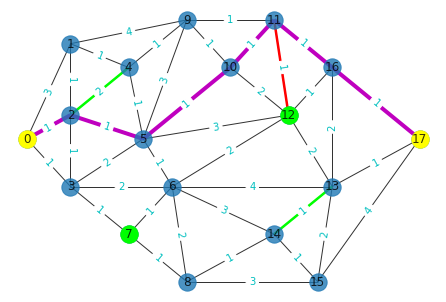

In [101]:
# 3.2 無限制條件的最短路徑
# 程式說明

# 對於無限制條件的最短路徑問題，NetworkX 提供了 Dijkstra 演算法、Bellman-Ford 演算法、Floyd 演算法和啟發式演算法 A* 的函式。
# 例程使用 nx.dijkstra_path() 和 nx.dijkstra_path_length() 呼叫 Dijkstra 演算法求兩個指定頂點之間的最短加權路徑和最短加權路徑長度。

# 兩個指定頂點之間的最短加權路徑
minWPath1 = nx.dijkstra_path(gAnt, source=0, target=17)  # 頂點 0 到 頂點 17 的最短加權路徑
# 兩個指定頂點之間的最短加權路徑的長度
lMinWPath1 = nx.dijkstra_path_length(gAnt, source=0, target=17)  #最短加權路徑長度
print("\n問題1: 無限制條件")
print("S 到 E 的最短加權路徑: ", minWPath1)
print("S 到 E 的最短加權路徑長度: ", lMinWPath1)

edgeList = []
for i in range(len(minWPath1)-1):
    edgeList.append((minWPath1[i],minWPath1[i+1]))
    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()


問題2: 禁止點或禁止邊的約束
S 到 E 的最短加權路徑:  [0, 3, 6, 12, 16, 17]
S 到 E 的最短加權路徑長度:  7


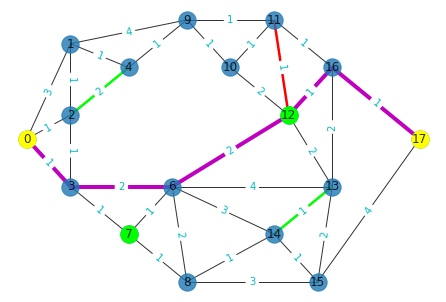

In [103]:
# 3.3 限制條件：禁止點或禁止邊
# 程式說明

# 禁止點或者禁止邊的處理比較簡單，從圖中刪除對應的禁止頂點或禁止邊即可。當然，在建立圖時就不新增這些頂點和邊更簡單，但這樣在繪圖時也無法反映這些頂點和邊。
# 使用 remove_node(n) 刪除指定頂點 n，remove_edge(u,v) 刪除指定的邊 (u,v)。
# 使用 remove_nodes_from([n1,...nk]) 刪除多個頂點，remove_edges_from([(u1,v1),...(uk,vk)]) 刪除多條邊。
# 例程中刪除的點和邊與案例問題中的要求不一致，是為了示例刪除函式的使用。下同。

# 2. 限制條件：禁止點或禁止邊
# 解決方案：從圖中刪除禁止頂點或禁止邊
gAnt.remove_nodes_from([5])  # 通過頂點標籤 5 刪除頂點
gAnt.remove_edge(13,17)  # 刪除邊 (13,17)
minWPath2 = nx.dijkstra_path(gAnt, source=0, target=17)  # 頂點 0 到 頂點 17 的最短加權路徑
lMinWPath2 = nx.dijkstra_path_length(gAnt, source=0, target=17)  #最短加權路徑長度
print("\n問題2: 禁止點或禁止邊的約束")
print("S 到 E 的最短加權路徑: ", minWPath2)
print("S 到 E 的最短加權路徑長度: ", lMinWPath2)

edgeList = []
for i in range(len(minWPath2)-1):
    edgeList.append((minWPath2[i],minWPath2[i+1]))
    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()


問題3: 一個必經點的約束
S 到 E 的最短加權路徑:  [0, 3, 6, 12, 16, 17]
S 到 E 的最短加權路徑長度:  7


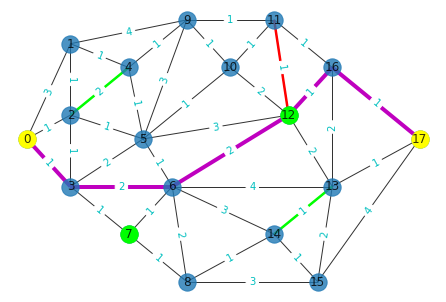

In [107]:
# 3.4 限制條件：一個必經點
# 程式說明

# 當限制條件為一個必經點時，可以把原問題分解為兩個子問題：子問題 1 為起點至必經點，子問題 2 為必經點至終點。
# 對兩個子問題分別用 Dijkstra 演算法求最短加權路徑和最短加權路徑長度，然後進行合併，就得到經過必經點的原問題的最短加權路徑和最短加權路徑長度。

# 3. 限制條件：一個必經點
# 解決方案：分解為兩個問題，問題 1 為起點N0至必經點N6，問題 2 為必經點N6至終點N17
minWPath3a = nx.dijkstra_path(gAnt, source=0, target=6)  # N0 到 N6 的最短加權路徑
lMinWPath3a = nx.dijkstra_path_length(gAnt, source=0, target=6)  # 最短加權路徑長度
minWPath3b = nx.dijkstra_path(gAnt, source=6, target=17)  # N6 到 N17 的最短加權路徑
lMinWPath3b = nx.dijkstra_path_length(gAnt, source=6, target=17)  # 最短加權路徑長度
minWPath3a.extend(minWPath3b[1:]) # 拼接 minWPath3a、minWPath3b 並去重 N7
print("\n問題3: 一個必經點的約束")
print("S 到 E 的最短加權路徑: ", minWPath3a)
print("S 到 E 的最短加權路徑長度: ", lMinWPath3a+lMinWPath3b)

edgeList = []
for i in range(len(minWPath3a)-1):
    edgeList.append((minWPath3a[i],minWPath3a[i+1]))
    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()


問題4: 多個必經點的約束
S 到 E 的最短加權路徑:  [0, 3, 7, 8, 14, 15, 13, 17]
S 到 E 的最短加權路徑長度:  8


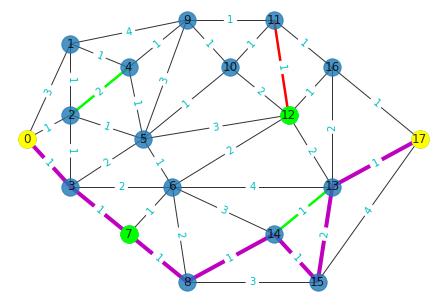

In [109]:
# 3.5 限制條件：多個必經點（方案一）
# 程式說明

# 當限制條件為兩個或多個必經點時，起點、終點與各必經點的次序並不確定，即從起點出發就不知道應該先去哪一個必經點，因此不宜再用分段求最小路徑的方法處理。
# NetworkX 提供了 all_simple_paths() 函式，可以生成兩個頂點之間的所有簡單路徑。利用簡單路徑演算法，可以通過對約束條件的判斷來求解帶有多個頂點約束的最短路徑問題。
# 程式實現的步驟包括：（1）遍歷起點為0、終點為17的簡單路徑；（2）檢查路徑是否滿足包括頂點 N7、N15 的限制條件；（3）在滿足限制條件的簡單路徑中找加權長度最短的路徑；（4）求最短路徑的加權路徑長度。
# 本段例程非常簡練，綜合使用了幾種 Python 語言迴圈、判斷結構的簡潔寫法，需要逐步分析。

# 4. 限制條件：多個必經點 (N7,N15)
# 解決方案：遍歷從起點到終點的簡單路徑，求滿足必經點條件的最短路徑
minWPath4 = min([path  # 返回 key 為最小值的 path
    for path in nx.all_simple_paths(gAnt, 0, 17)  # gAnt 中所有起點為0、終點為17的簡單路徑
    if all(n in path for n in (7, 15))], # 滿足路徑中包括頂點 N7,N15
    key=lambda x: sum(gAnt.edges[edge]['weight'] for edge in nx.utils.pairwise(x))) # key 為加權路徑長度
lenPath = sum(gAnt.edges[edge]['weight'] for edge in nx.utils.pairwise(minWPath4))  # 求指定路徑的加權路徑長度
print("\n問題4: 多個必經點的約束")
print("S 到 E 的最短加權路徑: ", minWPath4)
print("S 到 E 的最短加權路徑長度: ", lenPath)

edgeList = []
for i in range(len(minWPath4)-1):
    edgeList.append((minWPath4[i],minWPath4[i+1]))
    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()


問題5: 多個必經點的約束
S 到 E 的最短加權路徑:  [0, 3, 7, 8, 14, 15, 13, 17]
S 到 E 的最短加權路徑長度:  8


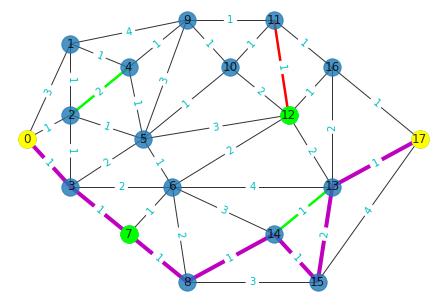

In [111]:
# 3.6 限制條件：多個必經點（方案二）
# 程式說明

# 本例與 3.5 的問題實際上是相同的。限制條件都是多個必經頂點 N7、N15，解決方案都是使用 all_simple_paths() 函式生成兩個頂點間的所有簡單路徑，程式實現的步驟也是類似的。
# 本方案按照典型的迴圈、判斷結構的寫法，便於閱讀和理解。此外，如果還有其它約束條件或子任務需要在迴圈中處理，這樣的結構更容易實現。

# 5. 限制條件：多個必經點 (N7,N15)
# 解決方案：遍歷從起點到終點的簡單路徑，求滿足必經點條件的最短路徑
lMinWPath5 = minWPath5 = 1e9
for path in nx.all_simple_paths(gAnt, 0, 17):
    if all(n in path for n in (7,15)):  # 滿足路徑中包括頂點 N7,N15
        lenPath = sum(gAnt.edges[edge]['weight'] for edge in nx.utils.pairwise(path))
        if lenPath < lMinWPath5:
            lMinWPath5 = lenPath
            minWPath5 = path
print("\n問題5: 多個必經點的約束")
print("S 到 E 的最短加權路徑: ", minWPath5)
print("S 到 E 的最短加權路徑長度: ", lMinWPath5)

edgeList = []
for i in range(len(minWPath5)-1):
    edgeList.append((minWPath5[i],minWPath5[i+1]))
    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()


問題6: 多個必經邊、必經點的約束
S 到 E 的最短加權路徑:  [0, 2, 4, 5, 6, 7, 8, 14, 13, 12, 16, 17]
S 到 E 的最短加權路徑長度:  13


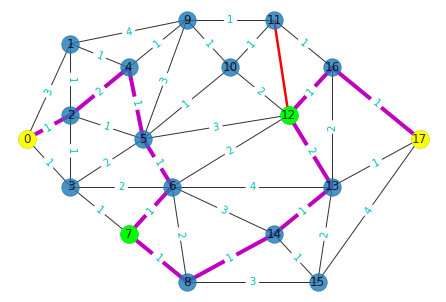

In [113]:
# 3.7 限制條件：必經邊
# 程式說明

# 必經點的處理，實際上還可以有更好的方法，其思想是結合 Dijkstra 演算法的實現過程， 將限制條件作為縮小搜尋空間的條件，可以降低演算法的複雜度。但對於多個必經邊來說，很難以此來改進基礎的無約束演算法，通常的處理方法就是在演算法中增加一個判斷是否滿足約束條件的過程。
# 本例仍然延續處理多個必經點的思路，利用簡單路徑演算法，可以通過對約束條件的判斷來求解帶有多個必經邊約束條件的最短路徑問題，可以同時處理必經點約束條件。
# 本例程對應案例中的各項約束條件： 必須經過圖中的綠色節點；必須經過圖中的兩段綠色路段；必須避開圖中的紅色路段；儘可能以最少的花費到達終點。
# 本例程的框架和步驟同 3.6，這是一個遍歷簡單路徑、判斷約束條件的通用框架。
# all(n in path for n in (2,4,7,12,13,14)) 的作用，一是判斷路徑中是否包括必經點 N7、N12；二是判斷路徑中是否包括必經邊 (2,4)、(13,14) 的各頂點，這不僅可以減小計算量，而且能確保下面使用 index() 查詢頂點位置時不會發生錯誤。

# 6. 限制條件：必經邊 (N2,N4), (N13,N14)，必經點 N7,N12
# 解決方案：遍歷從起點到終點的簡單路徑，求滿足必經邊條件的最短路徑
gAnt.remove_edge(11,12)  # 禁止邊 (11,12)
lMinWPath6 = minWPath6 = 1e9  # 置初值
for path in nx.all_simple_paths(gAnt, 0, 17):  # 所有起點為0、終點為17的簡單路徑
    if all(n in path for n in (2,4,7,12,13,14)): # 滿足路徑中包括頂點 N7,N12
        # 檢查 (N2,N4)
        p1 = path.index(2)  # N2 的位置
        if (path[p1-1]!=4 and path[p1+1]!=4): continue  # 判斷 N2~N4 是否相鄰
        # 檢查 (N13,N14)
        p2 = path.index(13)  # # N13 的位置
        if (path[p2-1]!=14 and path[p2+1]!=14): continue  # 判斷 N13~N14 是否相鄰
        lenPath = sum(gAnt.edges[edge]['weight'] for edge in nx.utils.pairwise(path))
        if lenPath < lMinWPath6:
            lMinWPath6 = lenPath
            minWPath6 = path

print("\n問題6: 多個必經邊、必經點的約束")
print("S 到 E 的最短加權路徑: ", minWPath6)
print("S 到 E 的最短加權路徑長度: ", lMinWPath6)

edgeList = []
for i in range(len(minWPath6)-1):
    edgeList.append((minWPath6[i],minWPath6[i+1]))

    
nx.draw(gAnt, pos, with_labels=True, alpha=0.8)
labels = nx.get_edge_attributes(gAnt,'weight')
nx.draw_networkx_edge_labels(gAnt,pos,edge_labels=labels, font_color='c') # 顯示權值
nx.draw_networkx_nodes(gAnt,pos,nodelist=[0,17],node_color='yellow')  # 設定頂點顏色
nx.draw_networkx_nodes(gAnt,pos,nodelist=[7,12],node_color='lime')  # 設定頂點顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(2,4),(13,14)],edge_color='lime',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=[(11,12)],edge_color='r',width=2.5)  # 設定邊的顏色
nx.draw_networkx_edges(gAnt,pos,edgelist=edgeList,edge_color='m',width=4)
plt.show()